<a href="https://colab.research.google.com/github/eduardodpms/cis_trainee_cnn/blob/main/CIS_Trainee_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Trainee CIS (4° Período) - Convolução***

Informações do *Trainee*:

- **Nome**: Eduardo de Pina Moreira Santos
- **Matrícula**: 231034494
- **Curso**: Engenharia de Software (FCTE)
- **E-mail**: eduardopms19@hotmail.com
- **Telefone**: (62)9 9994-1250

## **1. Introdução**

Este trabalho corresponde à atividade do 4° período do *Trainee* do capítulo estudantil da [*Computational Intelligence Society*](https://cis.ieee.org) do *IEEE*, na [Universidade de Brasília](https://www.unb.br). Demais informações do *Trainee* estão disponíveis no [*GitHub*](https://github.com/UnB-CIS/Trainee/tree/main). O foco dessa atividade é a elaboração de um modelo de Rede Neural Convolucional, utilizando bibliotecas do [*Python*](https://www.python.org) como [*Matplotlib*](https://matplotlib.org) e [*PyTorch*](https://pytorch.org). O *Dataset* de treino é o [*classificandos_nuvens_usando_cnn*](https://www.kaggle.com/competitions/classificandos-nuvens-usando-cnn/data), disponível no [*Kaggle*](https://www.kaggle.com).

O *Dataset* traz 474 imagens de treino e 486 de teste, nas quais estão representadas nuvens, subdivididas em classes. O objetivo da atividade é o desenvolvimento de um modelo de Rede Neural Convolucional de classificação *from scratch*, além da comparação do desempenho com uma rede pré-treinada, a fim de testar as habilidades do aluno no que tange à análise de dados e de *features* e à abordagem dos modelos.

## **2. Importações e *Data Augmentation***

### 2.1. Importação de Bibliotecas e Descompactação do *Dataset*

In [ ]:
!unzip clouds.zip > /dev/null # Descompacta o arquivo contendo o Dataset

In [ ]:
# Importação das bibliotecas necessárias
import torch # Biblioteca principal para computação em tensores
import torch.nn as nn # Módulo para construção de redes neurais
import torch.nn.functional as F # Versão funcional das operações da rede neural
import torch.optim as optim # Módulo com otimizadores para o treino
import matplotlib.pyplot as plt # Visualização de gráficos
from torchvision import datasets, models, transforms, utils # Ferramentas de carregamento e transformação de imagens

### 2.2. *Data Augmentation "on-the-fly"*

A primeira etapa crucial desse desenvolvimento é o *Data Augmentation*. Trata-se da aplicação de filtros diversos nas imagens de treino a fim de expandir a quantidade de elementos do conjunto. É uma técnica fundamental para *Datasets* com um número pequeno de dados (como o que está sendo trabalhado), a fim de garantir um treinamento aprimorado do modelo.

O *Data Augmentation*, aplicado aqui por meio do módulo `transforms`, é na modalidade "*on-the-fly*". Isso significa que as transformações só são aplicadas nas imagens quando elas são carregadas do `DataLoader`, de forma que o número total de amostras permaneça o mesmo.

In [ ]:
# Conjunto de Treino: resize, conversão para tensor e Augmentation
train_transform = transforms.Compose([
  transforms.Resize((224, 224)), # Redimensiona a imagem o tamanho padrão em CNNs
  transforms.RandomHorizontalFlip(), # Espelha horizontalmente com 50% de chance
  transforms.RandomRotation(30), # Rotaciona aleatoriamente até ±30 graus
  transforms.RandomResizedCrop(224, scale=(0.8, 1.0)), # Recorta uma região aleatória e redimensiona para 224x224
  transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2), # Variações na cor para simular efeitos de iluminação
  transforms.ToTensor(),]) # Converte para um tensor normalizado

# Conjunto de Teste: apenas resize e conversão para tensor
test_transform = transforms.Compose([
  transforms.Resize((224, 224)), # Redimensiona a imagem o tamanho padrão em CNNs
  transforms.ToTensor(),]) # Converte para um tensor normalizado

Depois de definidas as transformações, elas são aplicadas nas imagens que, por sua vez, são carregadas nos *DataLoaders*:

In [ ]:
# Aplica as transformações nos conjuntos de treino e de teste
train = datasets.ImageFolder('clouds/clouds_train', transform=train_transform)
test = datasets.ImageFolder('clouds/clouds_test', transform=test_transform)

# Carrega os conjuntos para um DataLoader do PyTorch
train_loader = torch.utils.data.DataLoader(train, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test, batch_size=32, shuffle=False)

Aqui, apenas um print para a visualização dos tamanhos originais dos conjuntos de treino e de teste:

In [ ]:
# Visualizar tamanho dos conjuntos no disco
print(f'Train Set size: {len(train)}') # Conjunto de treino
print(f'Test Set Size: {len(test)}') # Conjunto de teste

Train Set size: 474
Test Set Size: 486


Depois, cabe plotar alguns exemplos de imagens aumentadas para fins de visualização:

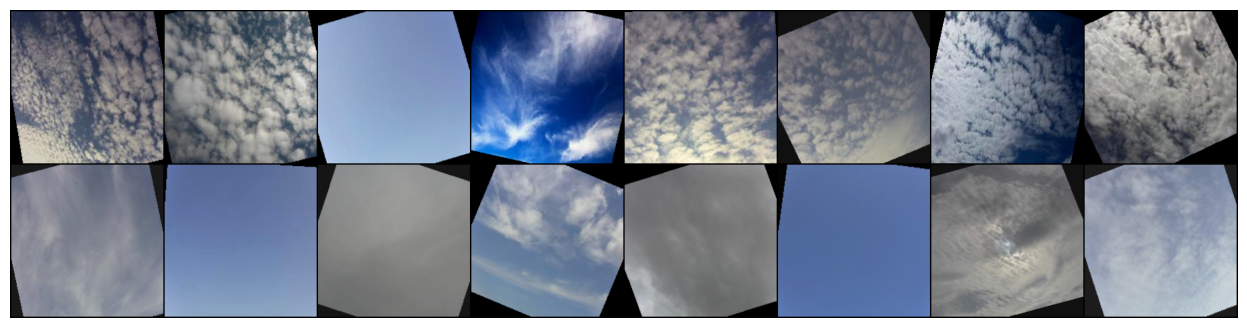

In [ ]:
# Visualizar exemplos de imagens aumentadas
images, labels = next(iter(train_loader))
grid_img = utils.make_grid(images[:16])
plt.figure(figsize=(20, 4))
plt.imshow(grid_img.permute(1, 2, 0))
plt.axis('off')
plt.show()

Nos exemplos, são perceptíveis:
- Imagens giradas, espelhadas e cortadas;
- Imagens com a coloração levemente alterada.

## **3. Elaboração da *Rede Convolucional***

Depois da etapa de *Data Augmentation* e do carregamento dos *DataLoaders*, a próxima etapa do desenvolvimento é a elaboração da *Rede Neural Convolucional* em si. Para uma construção *from scratch* usando o *PyTorch*, a sua arquitetura é definida da seguinte forma:

---

- **Camada Convolucional 1** (224×224×3):
  - *In Channels* = 3 (*RGB*), *Out Channels* = 32
  - *Kernel* 3×3 com *Padding* = 1
  - *Batch Normalization* (32 features)
  - *Função de Ativação* (*ReLU*)
  - *Pooling* (2x2) -> Saída: 112×112×32

- **Camada Convolucional 2** (112×112×32):
  - *In Channels* = 32, *Out Channels* = 64
  - *Kernel* 3×3 com *Padding* = 1
  - *Batch Normalization* (64 features)
  - *Função de Ativação* (*ReLU*)
  - *Pooling* (2x2) -> Saída: 56×56×64

- **Camada Fully-Connected 1** (64, 56, 56):
  - *Flatten* do vetor
  - *fc1* (Linear) - Comprime o vetor
  - *Função de Ativação* (ReLU)

- **Camada Fully-Connected 2** (256):
  - *fc2* (Linear) - Gera o vetor de saída
  - *Logits* (sem função de ativação)

---

Essa arquitetura traz benefícios como:
- Arquitetura compacta: poucas camadas;
- Velocidade e generalização: Combo BatchNorm + ReLU;
- Pooling: reduz dimensão e quantidade de parâmetros;
- Flexível: fácil adição de camadas extras, dropouts ou blocos residuais.

### 3.1. Definição de Classes

Aqui, há a definição da classe com base na arquitetura explicada na célula anterior:

In [ ]:
# Classe para uma Rede Neural Convolucional
class CNN(nn.Module):
  # Método de inicialização da classe
  def __init__(self, num_classes):
    super().__init__()  # Inicializa a superclasse nn.Module, base para modelos do PyTorch

    self.conv1 = nn.Conv2d(3, 32, 3, padding=1)  # Primeira camada convolucional, com padding
    self.bn1 = nn.BatchNorm2d(32)  # Normalização por lote para a primeira camada

    self.conv2 = nn.Conv2d(32, 64, 3, padding=1)  # Segunda camada convolucional, com padding
    self.bn2 = nn.BatchNorm2d(64) # Normalização por lote para a segunda camada

    self.pool = nn.MaxPool2d(2,2) # Camada de pooling 2x2 (reduz as dimensões pela metade)

    self.fc1 = nn.Linear(64 * 56 * 56, 256) # Primeira camada totalmente conectada (flatten da imagem reduzida)
    self.fc2 = nn.Linear(256, num_classes) # Saída totalmente conectada (um neurônio por classe)

  # Método para definição do fluxo de dados
  def forward(self, x):
    x = self.pool(F.relu(self.bn1(self.conv1(x)))) # Bloco conv1 → Batch Normalization → ReLU → Camada de Pooling
    x = self.pool(F.relu(self.bn2(self.conv2(x)))) # Bloco conv2 → Batch Normalization → ReLU → Camada de Pooling
    x = x.view(x.size(0), -1) # Achata o tensor para entrada na camada totalmente conectada
    x = F.relu(self.fc1(x)) # Camada de Ativação 'ReLU' da primeira camada totalmente conectada
    return self.fc2(x) # Saída final da rede (sem softmax)

Implementa-se também um *callback* de Early Stopping. De forma resumida, sua função é monitorar a possível ocorrência de *overfitting* durante o treinamento, analisando se houve ou não alguma melhora na acurácia nas `patience` últimas épocas de treino.

In [ ]:
# Classe para o callback Early Stopping
class EarlyStopping():
  # Método de inicialização da classe
  def __init__(self, patience=5):
    self.patience = patience # Define o número máximo de épocas sem melhora
    self.best_score = None # Armazena a melhor métrica observada
    self.early_stop = False # Flag para parar o treino
    self.counter = 0 # Contador de épocas sem melhora

  # Método de monitoramento da acurácia em cada época
  def __call__(self, score):
    if self.best_score is None: # Se for a primeira chamada
      self.best_score = score # Armazena a acurácia inicial como melhor
    elif (score <= self.best_score): # Se não houve melhora na métrica
      self.counter += 1 # Incrementa o contador de épocas sem melhora
      if self.counter >= self.patience: # Se ultrapassou a paciência
        self.early_stop = True # Ativa a flag de parada
    else: # Se houve melhora na acurácia
      self.best_score = score # Atualiza o valor da melhor acurácia
      self.counter = 0 # Reseta o contador

  # Método de reset da classe
  def reset(self):
    self.counter = 0 # Reseta o contador
    self.best_score = None # Reseta a melhor acurácia
    self.early_stop = False # Reseta a flag de parada

### 3.2. Definição de Parâmetros e Inicialização do Modelo

Definição de parâmetros gerais: *número de épocas*, *learning rate* e *paciência*:

In [ ]:
epochs = 20 # Número máximo de épocas
lr = 1e-4 # Learning Rate ou Taxa de Aprendizado
patience = 5 # Máximo de épocas sem melhora na acurácia
accuracies = [] # Lista de métricas de avaliação do modelo From Scratch

Aqui, há a migração (se possível) do ambiente do modelo para uma *GPU*, a fim de acelerar o treinamento:

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # Detecta se há núcleos CUDA (GPU)
print(device) # Printa o dispositivo encontrado

cuda


Depois, inicializa-se o modelo e o *callback* no dispositivo, e define o **otimizador** (*Adam*) e a **função de perda** (*Cross Entropy Loss*):

In [ ]:
model = CNN(len(train.classes)).to(device) # Inicializa o modelo
early_stopper = EarlyStopping(patience) # Inicializa o callback

optimizer = optim.Adam(model.parameters(), lr=lr) # Otimizador para o treino
criterion = nn.CrossEntropyLoss() # Função de perda utilizada pelo modelo

### 3.3. Treinamento e Validação do Modelo

Após as definições e inicializações do modelo, prossegue-se para o *loop* "principal" de treinamento do modelo, dividido em blocos:

- **Bloco de treinamento**: Define os pesos da rede com base em gradientes;
- **Bloco de validação**: Executa a predição para o lote de validação;
- **Bloco de avaliação**: Calcula e printa as métricas de avaliação da época;
- **Bloco de callbacks**: Aplica o *callback* **Early Stopping**.

In [ ]:
# Loop principal de treinamento (per epoch)
for epoch in range(1, epochs+1):

  # Bloco de treinamento
  model.train() # Coloca o modelo em modo de treinamento
  train_loss, train_correct = 0.0, 0 # Inicializa acumuladores de perda e de acertos do treino
  for imgs, labels in train_loader: # Loop pelos lotes de treino
    imgs, labels = imgs.to(device), labels.to(device) # Move dados para a CPU ou GPU
    optimizer.zero_grad() # Zera os gradientes anteriores
    outputs = model(imgs) # Executa o forward pass (predição)
    loss = criterion(outputs, labels) # Calcula a perda do lote de treino
    loss.backward() # Backpropagation: calcula os gradientes
    optimizer.step() # Atualiza os pesos da rede com base nos gradientes

    train_loss += loss.item() * imgs.size(0) # Acumula a perda ponderada pelo tamanho do lote
    _, preds = outputs.max(1) # Obtém as classes previstas (com maior probabilidade)
    train_correct += (preds == labels).sum().item() # Conta quantas predições foram corretas

  # Bloco de validação
  model.eval() # Coloca o modelo em modo de avaliação
  val_loss, val_correct = 0.0, 0 # Inicializa acumuladores de perda e de acertos da validação
  with torch.no_grad(): # Desativa o cálculo de gradientes (torna mais rápido e leve)
    for imgs, labels in test_loader: # Loop pelos lotes de validação
      imgs, labels = imgs.to(device), labels.to(device) # Move dados para a CPU ou GPU
      outputs = model(imgs) # Executa o forward pass (predição)
      loss = criterion(outputs, labels) # Calcula a perda do lote de validação

      val_loss += loss.item() * imgs.size(0) # Acumula a perda ponderada pelo tamanho do lote
      _, preds = outputs.max(1) # Obtém as classes previstas (com maior probabilidade)
      val_correct += (preds == labels).sum().item() # Conta quantas predições foram corretas

  # Bloco de avaliação
  n_train, n_val = len(train_loader.dataset), len(test_loader.dataset) # Tamanhos dos conjuntos de treino e de validação
  train_acc, val_acc = (100 * train_correct / n_train), (100 * val_correct / n_val) # Acurácias de treino e de validação, em %
  accuracies.append([train_acc, val_acc]) # Armazena as acurácias de treino e de validação da época em uma lista

  print(f"Epoch {epoch:02d}/{epochs} | " # Print com a contagem da época atual
        f"Train Loss: {train_loss/n_train:.4f}, Train Acc: {train_acc:.2f}% | " # Print com as métricas de treino da época atual
        f"Val Loss: {val_loss/n_val:.4f}, Val Acc: {val_acc:.2f}%") # Print com as métricas de avaliação da época atual

  # Bloco de callbacks (Early Stopping)
  early_stopper(val_acc) # Chama o Early Stopper para interpretar a evolução da acurácia

  if early_stopper.early_stop: # Se a acurácia não melhorou por N épocas consecutivas
    early_stopper.reset() # Reseta o estado do early stopping (opcional)
    print(f"{'-'*27} ⏹ Early Stopping after epoch {epoch} {'-'*27}") # Avisa que houve um Early Stopping
    break # Interrompe o treinamento

Epoch 01/20 | Train Loss: 5.1725, Train Acc: 25.53% | Val Loss: 1.7152, Val Acc: 25.31%
Epoch 02/20 | Train Loss: 1.5761, Train Acc: 41.98% | Val Loss: 1.5830, Val Acc: 41.15%
Epoch 03/20 | Train Loss: 1.2047, Train Acc: 52.32% | Val Loss: 1.2649, Val Acc: 48.77%
Epoch 04/20 | Train Loss: 1.1282, Train Acc: 55.49% | Val Loss: 1.0328, Val Acc: 57.41%
Epoch 05/20 | Train Loss: 1.0366, Train Acc: 60.13% | Val Loss: 0.9940, Val Acc: 60.70%
Epoch 06/20 | Train Loss: 0.9777, Train Acc: 64.35% | Val Loss: 1.1999, Val Acc: 50.41%
Epoch 07/20 | Train Loss: 0.9844, Train Acc: 62.87% | Val Loss: 0.9570, Val Acc: 61.93%
Epoch 08/20 | Train Loss: 0.9594, Train Acc: 62.87% | Val Loss: 0.8051, Val Acc: 70.58%
Epoch 09/20 | Train Loss: 0.8269, Train Acc: 66.46% | Val Loss: 0.7781, Val Acc: 71.40%
Epoch 10/20 | Train Loss: 0.7581, Train Acc: 71.10% | Val Loss: 0.8580, Val Acc: 66.26%
Epoch 11/20 | Train Loss: 0.7542, Train Acc: 72.57% | Val Loss: 0.9433, Val Acc: 64.20%
Epoch 12/20 | Train Loss: 0.8042

### 3.4. Avaliação do Modelo

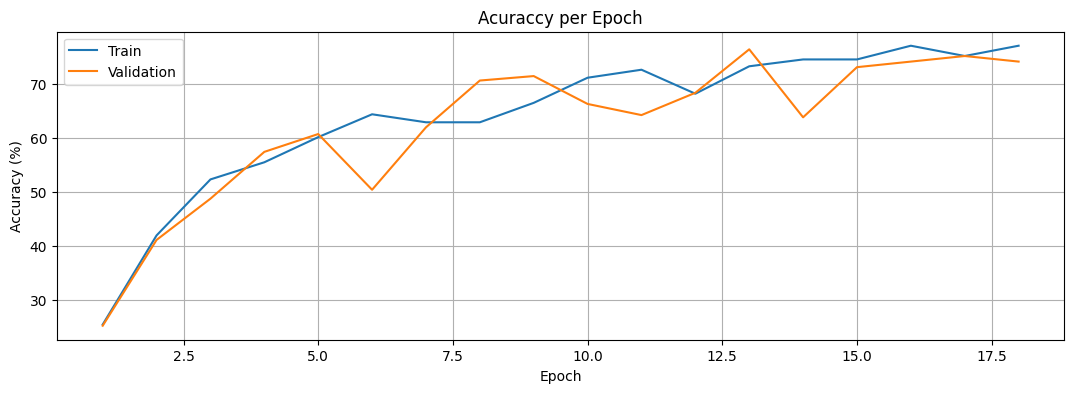

In [ ]:
# Gráfico de Acurácia x Época para treino e validação
plt.figure(figsize=(13, 4))
plt.plot(range(1, len(accuracies) + 1), [acc[0] for acc in accuracies], label='Train') # Gráfico com os dados de treino
plt.plot(range(1, len(accuracies) + 1), [acc[1] for acc in accuracies], label='Validation') # Gráfico com os dados de validação
plt.title("Acuraccy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid(True)
plt.show()

Após o treinamento do modelo *from scratch* por `20` épocas, com *Early Stopping* na 18°, uma acurácia de validação máxima de `76.34%` e final de `74.07%`, o modelo apresentou um desempenho aceitável-bom, dadas as condições, como o tamanho reduzido do conjunto de treino.

## **4. Aplicação da *Rede Pré-Treinada (Transfer Learning)***

Para fins de comparação, será proposta uma abordagem adicional neste desenvolvimento: o uso de uma rede pré-treinada.

De forma resumida, uma **rede pré-treinada** é uma rede neural que já passou pelo processo de treinamento em uma base de dados grande e, portanto, já tem os seus pesos ajustados. Para o problema, ela será utilizada em conjunto com o **transfer learning**, um processo de ajuste dos pesos da rede para uma nova tarefa ou *Dataset*, de forma semelhante a um treinamento convencional.

Nesta abordagem, é esperado que a **rede pré-treinada** apresente resultados melhores que a rede *from scratch*, uma vez que o tamanho reduzido do *Dataset* não permitiu um ajuste fino dos pesos e que os pesos da rede "importada" já estão ajustados parcialmente. A rede utilizada será a `ResNet18`, por se tratar de um modelo fundamentado para contextos semelhantes a esse.


### 3.1. Definição de Parâmetros e Inicialização do Modelo

A primeira etapa é a definição de parâmetros gerais: *número de épocas*, *learning rate* e *paciência*:

In [ ]:
tl_epochs = 20 # Número máximo de épocas
tl_lr = 1e-3 # Learning Rate ou Taxa de Aprendizado
tl_patience = 5 # Máximo de épocas sem melhora na acurácia
tl_accuracies = [] # # Lista de acurácias do modelo Pré-Treinado

Em sequência, o modelo `ResNet18` é carregado e tem seus parâmetros congelados:

In [ ]:
tl_model = models.resnet18(weights='ResNet18_Weights.DEFAULT') # Carrega o modelo 'ResNet18' pré-treinado

for param in tl_model.parameters(): # Loop para evitar o treinamento das camadas prévias
  param.requires_grad = False # Congela os parâmetros

tl_model.fc = nn.Linear(tl_model.fc.in_features, len(train.classes)) # Remodela a última camada de acordo com as classes do dataset

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 172MB/s]


Depois, carrega-se o modelo e o *callback* no dispositivo, e define o **otimizador** (*Adam*) e a **função de perda** (*Cross Entropy Loss*):

In [ ]:
tl_model = tl_model.to(device) # Carrega o modelo para GPU ou CPU
tl_early_stopper = EarlyStopping(tl_patience) # Inicializa o callback

tl_optimizer = optim.Adam(tl_model.fc.parameters(), lr=tl_lr) # Otimizador para o treino
tl_criterion = nn.CrossEntropyLoss() # Função de perda utilizada pelo modelo

### 3.2. Treinamento e Validação do Modelo

A atualização de parâmetros de um modelo pré-treinado, nesse caso, seguirá as exatas mesmas etapas do processo de treinamento da rede *from scratch*. Assim, o trecho de código referente ao *loop* de treinamento dele foi reciclado:

In [ ]:
# Loop principal de treinamento (per epoch)
for epoch in range(1, tl_epochs+1):

  # Bloco de treinamento
  tl_model.train() # Coloca o modelo em modo de treinamento
  train_loss, train_correct = 0.0, 0 # Inicializa acumuladores de perda e de acertos do treino
  for imgs, labels in train_loader: # Loop pelos lotes de treino
    imgs, labels = imgs.to(device), labels.to(device) # Move dados para a CPU ou GPU
    tl_optimizer.zero_grad() # Zera os gradientes anteriores
    outputs = tl_model(imgs) # Executa o forward pass (predição)
    loss = tl_criterion(outputs, labels) # Calcula a perda do lote de treino
    loss.backward() # Backpropagation: calcula os gradientes
    tl_optimizer.step() # Atualiza os pesos da rede com base nos gradientes

    train_loss += loss.item() * imgs.size(0) # Acumula a perda ponderada pelo tamanho do lote
    _, preds = outputs.max(1) # Obtém as classes previstas (com maior probabilidade)
    train_correct += (preds == labels).sum().item() # Conta quantas predições foram corretas

  # Bloco de validação
  tl_model.eval() # Coloca o modelo em modo de avaliação
  val_loss, val_correct = 0.0, 0 # Inicializa acumuladores de perda e de acertos da validação
  with torch.no_grad(): # Desativa o cálculo de gradientes (torna mais rápido e leve)
    for imgs, labels in test_loader: # Loop pelos lotes de validação
      imgs, labels = imgs.to(device), labels.to(device) # Move dados para a CPU ou GPU
      outputs = tl_model(imgs) # Executa o forward pass (predição)
      loss = tl_criterion(outputs, labels) # Calcula a perda do lote de validação

      val_loss += loss.item() * imgs.size(0) # Acumula a perda ponderada pelo tamanho do lote
      _, preds = outputs.max(1) # Obtém as classes previstas (com maior probabilidade)
      val_correct += (preds == labels).sum().item() # Conta quantas predições foram corretas

  # Bloco de avaliação
  n_train, n_val = len(train_loader.dataset), len(test_loader.dataset) # Tamanhos dos conjuntos de treino e de validação
  train_acc, val_acc = (100 * train_correct / n_train), (100 * val_correct / n_val) # Acurácias de treino e de validação, em %
  tl_accuracies.append([train_acc, val_acc]) # Armazena as acurácias de treino e de validação da época em uma lista

  print(f"[TL] Epoch {epoch:02d}/{epochs} | " # Print com a contagem da época atual
        f"Train Loss: {train_loss/n_train:.4f}, Train Acc: {train_acc:.2f}% | " # Print com as métricas de treino da época atual
        f"Val Loss: {val_loss/n_val:.4f}, Val Acc: {val_acc:.2f}%") # Print com as métricas de avaliação da época atual

  # Bloco de callbacks (Early Stopping)
  tl_early_stopper(val_acc) # Chama o Early Stopper para interpretar a evolução da acurácia

  if tl_early_stopper.early_stop: # Se a acurácia não melhorou por N épocas consecutivas
    tl_early_stopper.reset() # Reseta o estado do early stopping (opcional)
    print(f"{'-'*29} ⏹ Early Stopping after epoch {epoch} {'-'*29}") # Avisa que houve um Early Stopping
    break # Interrompe o treinamento

[TL] Epoch 01/20 | Train Loss: 1.7590, Train Acc: 33.97% | Val Loss: 1.6850, Val Acc: 32.30%
[TL] Epoch 02/20 | Train Loss: 1.3485, Train Acc: 52.74% | Val Loss: 1.2214, Val Acc: 63.58%
[TL] Epoch 03/20 | Train Loss: 1.0628, Train Acc: 72.57% | Val Loss: 0.8864, Val Acc: 77.98%
[TL] Epoch 04/20 | Train Loss: 0.8615, Train Acc: 77.85% | Val Loss: 0.7260, Val Acc: 81.07%
[TL] Epoch 05/20 | Train Loss: 0.7771, Train Acc: 75.74% | Val Loss: 0.6338, Val Acc: 84.57%
[TL] Epoch 06/20 | Train Loss: 0.7019, Train Acc: 81.86% | Val Loss: 0.5868, Val Acc: 83.95%
[TL] Epoch 07/20 | Train Loss: 0.6767, Train Acc: 79.32% | Val Loss: 0.5095, Val Acc: 87.45%
[TL] Epoch 08/20 | Train Loss: 0.5893, Train Acc: 83.54% | Val Loss: 0.4729, Val Acc: 88.48%
[TL] Epoch 09/20 | Train Loss: 0.5448, Train Acc: 85.65% | Val Loss: 0.4399, Val Acc: 88.48%
[TL] Epoch 10/20 | Train Loss: 0.5014, Train Acc: 87.97% | Val Loss: 0.4270, Val Acc: 88.89%
[TL] Epoch 11/20 | Train Loss: 0.4963, Train Acc: 85.44% | Val Loss: 0

### 3.3. Avaliação do Modelo

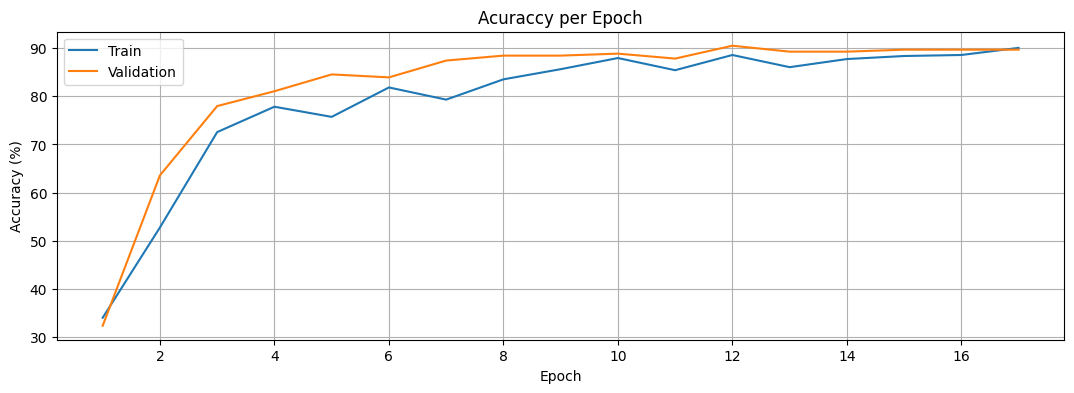

In [ ]:
# Gráfico de Acurácia x Época para treino e validação
plt.figure(figsize=(13, 4))
plt.plot(range(1, len(tl_accuracies) + 1), [acc[0] for acc in tl_accuracies], label='Train') # Gráfico com os dados de treino
plt.plot(range(1, len(tl_accuracies) + 1), [acc[1] for acc in tl_accuracies], label='Validation') # Gráfico com os dados de validação
plt.title("Acuraccy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid(True)
plt.show()

Aqui, foi observado um treinamento mais suave e mais preciso, com `20` épocas e um *Early Stopping* na 17°. Obteve-se uma acurácia de validação máxima de `90.53%` e final de `89.71%`. O modelo pré-treinado apresentou um desempenho ótimo para o *Dataset* utilizado.

## **5. Comparação dos Modelos**

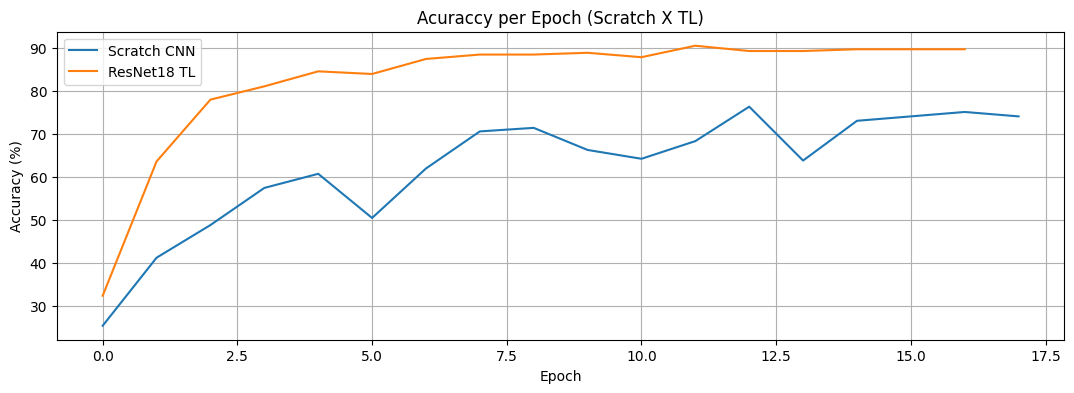

In [ ]:
# Gráfico de Acurácia x Época para as redes from Scratch e pré treinada
plt.figure(figsize=(13, 4))
plt.plot([acc[1] for acc in accuracies], label='Scratch CNN')
plt.plot([acc[1] for acc in tl_accuracies], label='ResNet18 TL')
plt.title("Acuraccy per Epoch (Scratch X TL)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid(True)
plt.show()

Por fim, cabe uma análise comparativa das acurácias de validação dos modelos *from scratch* (azul) e *pré-treinado* (laranja).

Enquanto a rede "construída" apresentou instabilidade na validação, considerando que o tamanho limitado do *Dataset* trouxe uma maior sensibilidade para a convolução, a rede "importada" demonstrou suavidade na evolução da acurácia, o que, dentre outras qualidades, facilita a identificação de *overfitting* e reforça a confiabilidade e reprodutividade do modelo.

Quanto às acurácias em si, é perceptível como a rede pré-treinada trouxe resultados superiores, que circundam de forma estável o valor de `90%` após a 10° época. Por outro lado, as acurácias do modelo *from scratch*, no qual os pesos foram definidos "do zero", não parecem se estabilizar em torno de um valor único, o que pode trazer valores na faixa aproximada de `65%` até `75%`.

## **6. Conclusão**

Com um desenvolvimento que abrangeu áreas diversas como *Data Augmentation* no *Dataset* e criação de *callbacks*, foi possível o desenvolvimento de modelos robustos dadas as condições de tamanho reduzido do conjunto de dados fornecidas (que dificultavam o refinamento dos pesos). O modelo *from scratch* atingiu uma acurácia final de `74.07%`, enquanto o modelo *pré-treinado*, com *transfer learning*, atingiu uma acurácia final de `89.71`, ambos com uso do *callback* "*Early Stopping*".

Além disso, foi feito também um estudo direcionado para a comparação dos resultados de acurácia obtidos por esses dois modelos, o qual mostrou que a rede *pré-treinada* obteve uma evolução suave e reprodutível, enquanto o modelo *from scratch* apresentou instabilidade e, por vezes, aleatoridade. Essa comparação ressalta a diferença no príncipio dos modelos, mostrando como o ajuste prévio dos pesos pode impactar em uma rede convolucional, até mesmo com *Datasets* limitados.

## **7. Bibliografia**

- 1. MYRON, R. **Classificando Nuvens Usando CNN**. Kaggle. Disponível em: https://www.kaggle.com/competitions/classificandos-nuvens-usando-cnn/data. Acesso em: 13 jun. 2025.
- 2. **What are convolutional neural networks?** International Business Machines Corporation. Disponível em: https://www.ibm.com/think/topics/convolutional-neural-networks. Acesso em: 13 jun. 2025.
- 3. **O que é aumento de dados?** Amazon Web Services. Disponível em: https://aws.amazon.com/what-is/data-augmentation/. Acesso em: 13 jun. 2025.
- 4. MARCELINO, P. **Transfer learning from pre-trained models.** Medium. Disponível em: https://medium.com/data-science/transfer-learning-from-pre-trained-models-f2393f124751. Acesso em: 14 jun. 2025.











